### Calibrate all floats that have oxygen data
*Create a local copy of Argo data, match it to World Ocean Atlas, and correct it to match climatology*

Use the `load_biofloat_cache.py` script to create a local cache file of all the data we want to work with:

```bash
load_biofloat_cache.py --age 365 -v >> age365.out 2>&1 &
```

This script takes several days to complete and needs to be monitored as it depends on Internet resources which occaisonally fail to respond. The `load_biofloat_cache.py` can be killed and restarted as necessary to deal with these interruptions (a `scripts/load_biofloat_cache_watchdog.sh` bash script is provided to do this automatically for you from cron on Unix systems). We save the logger output to a log file (`age365.out`) to facilitate analysis of the data load. When this script was executed in December of 2015 it produced an 1.5 GB file (`biofloat_fixed_cache_age365_variablesDOXY_ADJUSTED-PSAL_ADJUSTED-TEMP_ADJUSTED.hdf`) which we can explore using ArgoData.

In [1]:
from biofloat import ArgoData
from os.path import join, expanduser
ad = ArgoData(cache_file = join(expanduser('~'), 
     'biofloat_fixed_cache_age365_variablesDOXY_ADJUSTED-PSAL_ADJUSTED-TEMP_ADJUSTED.hdf'))

In [2]:
ocdf = ad.get_cache_file_oxy_count_df()
print ocdf.groupby('wmo').sum().sum()
print 'Float having DOXY_ADJUSTED data:', ocdf.wmo.count()
acdf = ad.get_cache_file_all_wmo_list()
print 'Number of floats examined:', len(acdf)

num_measurements    10264887
num_profiles           42537
dtype: int64
Float having DOXY_ADJUSTED data: 301
Number of floats examined: 559


That's over 10 million measurements from over 42,000 profiles from 301 floats. The `load_biofloat_cache.py` script examined 559 floats for valid oxygen data. All of the profile data are in this file and the data from any float can be explored as demonstrated in the Notebooks [explore_cached_biofloat_data.ipynb](explore_cached_biofloat_data.ipynb) and [explore_surface_oxygen_and_WOA.ipynb](explore_surface_oxygen_and_WOA.ipynb).

---

To compare these data against the World Ocean Atlas database the `woa_calibration.py` script can be executed in the home directory:

```bash
woa_calibration.py --cache_file \
biofloat_fixed_cache_age365_variablesDOXY_ADJUSTED-PSAL_ADJUSTED-TEMP_ADJUSTED.hdf \
--results_file woa_lookup_age365.hdf -v
```

This script takes a few hours to complete, but once it's done we have surface monthly oxygen saturation data from Argo floats together with WOA 2013 oxygen saturarion data.

Let's load in the `woa_calibration.py` generated data into a DataFrame.

In [3]:
import pandas as pd
df = pd.DataFrame()
with pd.HDFStore(join(expanduser('~'), 'woa_lookup_age365.hdf')) as s:
    wmo_list = ocdf.wmo
    for wmo in wmo_list:
        try:
            fdf = s.get(('/WOA_WMO_{}').format(wmo))
        except KeyError:
            pass
        if not fdf.dropna().empty:
            df = df.append(fdf)

print df.head()
print df.describe()
print 'Number of floats with corresponding WOA data:', len(df.index.get_level_values('wmo').unique())

                         o2sat   woa_o2sat      wmo       date      gain
wmo     year month                                                      
1901158 2011 2      360.619832  105.071640  1901158 2011-02-01  0.291364
             3      351.939087  104.036407  1901158 2011-03-01  0.295609
             4      342.336582  102.895668  1901158 2011-04-01  0.300569
             5      331.277857  101.628204  1901158 2011-05-01  0.306776
             6      318.694409   98.690773  1901158 2011-06-01  0.309672
                 o2sat    woa_o2sat         gain
count      8785.000000  8751.000000  8751.000000
mean       8747.119041   100.316019          inf
std      804472.199479     4.251295          NaN
min        -491.189964    74.906464  -483.202681
25%          89.600800    98.303253     1.025494
50%          93.904908   100.792801     1.068379
75%          97.844237   102.866020     1.109695
max    75400732.773012   116.850693          inf
Number of floats with corresponding WOA data: 29

The `inf` and `NaN` values in the statistics of the gain indicate bad data, let's restrict data to a reasonably valid range of the measured o2sat.

In [4]:
qdf = df.query('(o2sat > 50 ) & (o2sat < 200)')
qdf.describe()

,o2sat,woa_o2sat,gain
count,8291.000000,8257.000000,8257.000000
mean,94.715804,100.351075,1.071105
std,11.509529,4.228237,0.110756
min,50.240882,74.906464,0.502262
25%,90.112790,98.356178,1.032317
50%,94.002933,100.802185,1.070336
75%,97.729826,102.892311,1.109654
max,199.698198,116.850693,2.104910


Plot the distribution of gains from this minimally qc'ed data &mdash; comparible to Figure 4 in [Takeshita _et al._ (2013)](http://onlinelibrary.wiley.com/doi/10.1002/jgrc.20399/abstract).

Populating the interactive namespace from numpy and matplotlib


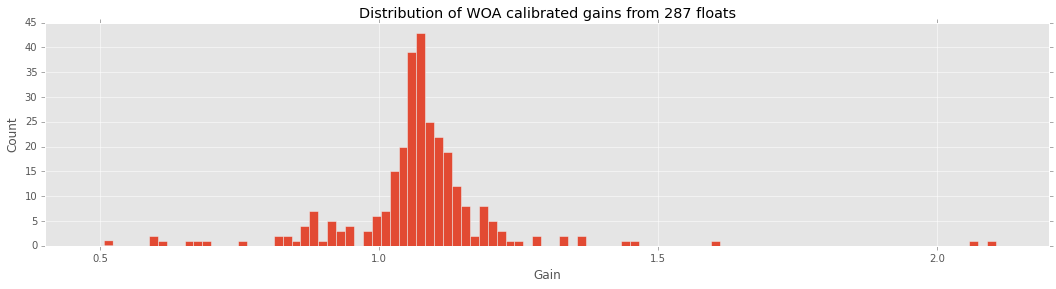

In [5]:
%pylab inline
import pylab as plt
plt.rcParams['figure.figsize'] = (18.0, 4.0)
plt.style.use('ggplot')
ax = qdf.groupby('wmo').mean().gain.hist(bins=100)
ax.set_xlabel('Gain')
ax.set_ylabel('Count')
floats = qdf.index.get_level_values('wmo').unique()
ax.set_title(('Distribution of WOA calibrated gains from {} floats').format(len(floats)))

Plot time series of gain for all the floats and fit an ordinary least squares regression to detect any drift in time of the gain for all the floats.

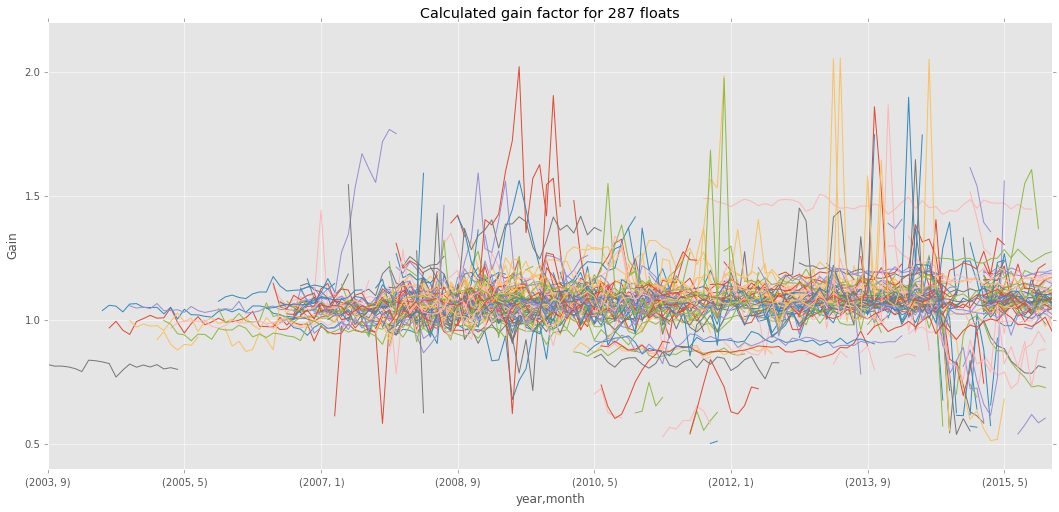

In [6]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
ax = qdf.unstack(level='wmo').gain.plot()
ax.set_ylabel('Gain')
ax.set_title(('Calculated gain factor for {} floats').format(len(floats)))
ax.legend_.remove()

Make a list of all the floats in `qdf` and assign a color to each.

In [7]:
wmo_list = qdf.index.get_level_values('wmo').unique()
colors = cm.spectral(np.linspace(0, 1, len(wmo_list)))
print 'Number of floats with reasonable oxygen saturation values:', len(wmo_list)

Number of floats with reasonable oxygen saturation values: 287


Make scatter plot of float oxygen saturation vs. World Ocean Atlas oxygen saturation.

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


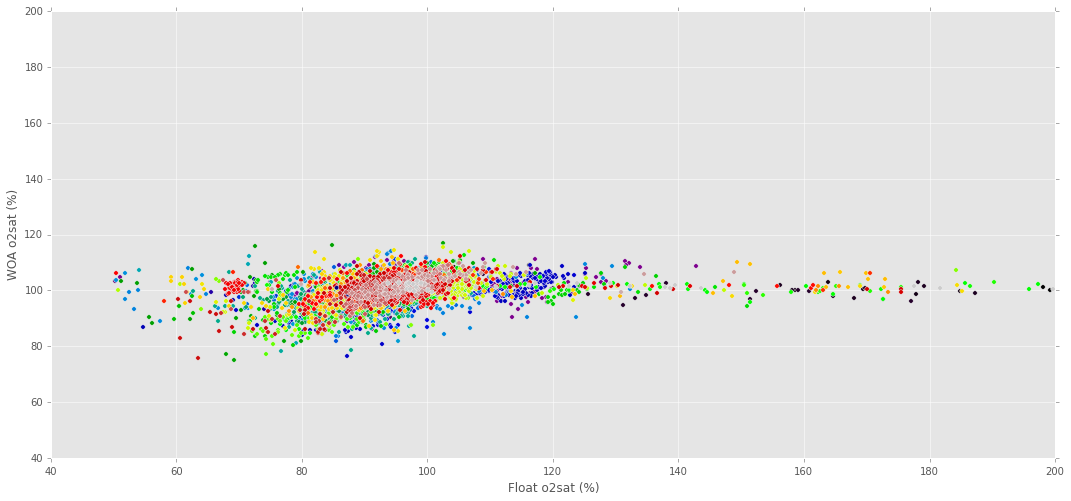

In [8]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, 1)
for wmo, c in zip(wmo_list, colors):
    ax.scatter(qdf.xs(wmo, level='wmo')['o2sat'], qdf.xs(wmo, level='wmo')['woa_o2sat'], c=c)
ax.set_xlim([40, 200])
ax.set_ylim([40, 200])
ax.set_xlabel('Float o2sat (%)')
ax.set_ylabel('WOA o2sat (%)')

This first look at WOA oxygen calibration for all the Argo floats reveals that there are some issues with the data that warrant further exploration.